# Clustering Maddo

In [48]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import pandas as pd
from scipy.signal import stft
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [49]:
import pandas as pd
import numpy as np     
import matplotlib.pyplot as plt
import seaborn as sns

fragmenten_df = pd.read_csv('Data/fragments_data.csv')
affinityFragmenten_df = fragmenten_df.copy()
affinityFragmenten_df.head()

,fragment,labels,label_numeric
0,05190.100417.watersniproepEempolder_fragment_0...,watersnip,0
1,05190.100417.watersniproepEempolder_fragment_1...,watersnip,0
2,05190.100417.watersniproepEempolder_fragment_2...,watersnip,0
3,05190.100417.watersniproepEempolder_fragment_3...,watersnip,0
4,05190.100417.watersniproepEempolder_fragment_4...,watersnip,0


In [50]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(affinityFragmenten_df, test_size=0.3, random_state=42)
test_data.head()

,fragment,labels,label_numeric
948,XC466471-Redshank (2)_fragment_0.wav,tureluur,1
3036,XC749107-2022-09-14 2020 Oeverlopers_fragment_...,oeverloper,4
1960,XC590410-200918_0480_2257_Watersnip_fragment_1...,watersnip,0
3543,XC834752-01.-1950-2050-watersnip_fragment_5.wav,watersnip,0
1689,"XC561755-Oeverloper, flight call, IGS, 050520,...",oeverloper,4


In [51]:
label_counts = test_data['labels'].value_counts()
print(label_counts)

labels
tureluur                  362
oeverloper                256
witgat                    202
watersnip                 170
zwarte ruiter             149
geelpootruiter             11
grauwe franjepoot          10
steenloper                  7
steltloper                  3
amerikaanse oeverloper      1
Name: count, dtype: int64


In [52]:
for fragment in test_data['fragment']:
    y, sr = librosa.load("audio_fragments/" + fragment, sr=None)

In [53]:
# Initialize the features and filenames lists
features = []
filenames = []

for fragment in test_data['fragment']:
    y, sr = librosa.load("audio_fragments/" + fragment, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0)

    _, _, Zxx = stft(y, sr, nperseg=1024)
    stft_mean = np.mean(np.abs(Zxx))

    stft_librosa = librosa.stft(y, n_fft=1024, hop_length=512)
    stft_librosa_mean = np.mean(np.abs(stft_librosa))

    feature_vector = np.concatenate([mfcc_mean, [stft_mean], [stft_librosa_mean]])
    features.append(feature_vector)
    filenames.append(fragment)

features = np.array(features)

scaler = StandardScaler()
features = scaler.fit_transform(features)

distance_matrix = squareform(pdist(features, metric='euclidean'))

c:\Users\madel\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1083
  warnings.warn(
c:\Users\madel\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=369
  warnings.warn(
c:\Users\madel\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1240: UserWarning: nperseg = 1024 is greater than input length  = 369, using nperseg = 369
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
c:\Users\madel\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=369
  warnings.warn(
c:\Users\madel\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=645
  warnings.warn(
c:\Users\madel\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1240: UserWarning: nperseg = 1024 is greater than input l

In [54]:
# Filter out low-energy fragments
filtered_fragments = []
for fragment in test_data['fragment']:
    y, sr = librosa.load("audio_fragments/" + fragment, sr=None)
    if np.mean(np.abs(y)) >= 0.01:  # Adjust threshold as needed
        filtered_fragments.append(fragment)

for fragment in test_data['fragment']:
    try:
        y, sr = librosa.load("audio_fragments/" + fragment, sr=None)
        if len(y) < 2048 or np.mean(np.abs(y)) < 0.01:
            # print(f"Skipping fragment {fragment}: too short or low energy")
            continue
        # Proceed with feature extraction
    except Exception as e:
        print()
        # print(f"Error processing fragment {fragment}: {e}")

# Extract features for filtered fragments
features = []
for fragment in filtered_fragments:
    y, sr = librosa.load("audio_fragments/" + fragment, sr=None)
    n_fft = min(2048, len(y))  # Adjust n_fft to the signal length
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=n_fft)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft)
    chroma_mean = np.mean(chroma.T, axis=0)
    feature_vector = np.concatenate([mfcc_mean, chroma_mean])
    features.append(feature_vector)

features = np.array(features)
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Perform Affinity Propagation with adjusted parameters
affinity = AffinityPropagation(random_state=42)
cluster_labels = affinity.fit_predict(features)

c:\Users\madel\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [55]:
# Ensure features array is valid before applying t-SNE
if np.isnan(features).any() or np.isinf(features).any():
    print("Error: Features array contains NaN or infinite values. Please check your data.")
else:
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

print(f"Shape of features_tsne: {features_tsne.shape}")

Shape of features_tsne: (335, 2)


filtered_fragments: 335
Shape of features array: (335, 25)
cluster_labels: 335
Shape of features_tsne: (335, 2)


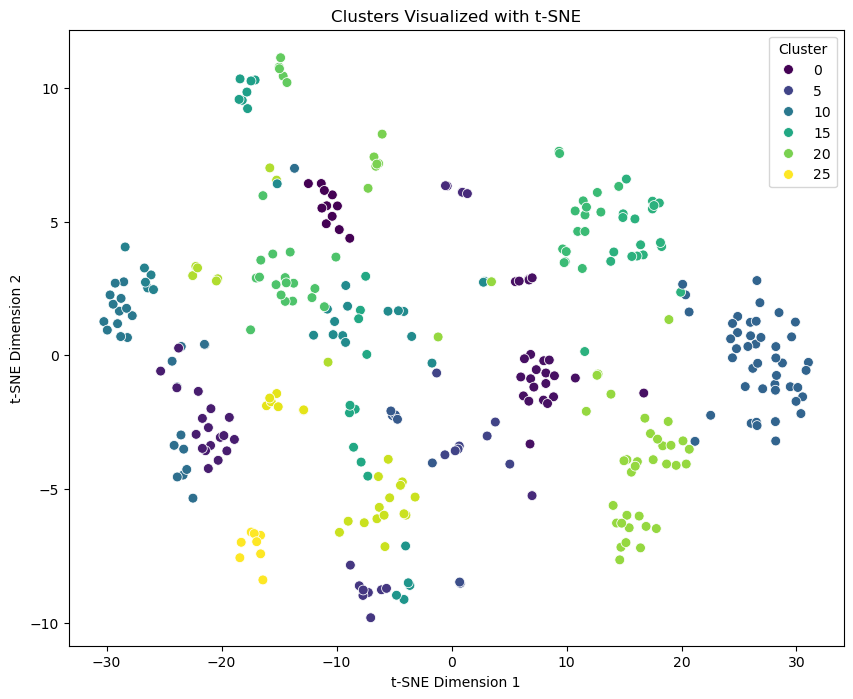

In [56]:
print(f"filtered_fragments: {len(filtered_fragments)}")
print(f"Shape of features array: {features.shape}")
print(f"cluster_labels: {len(cluster_labels)}")
print(f"Shape of features_tsne: {features_tsne.shape}")

# # Visualize clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.title("Clusters Visualized with t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster", loc='best')
plt.show()

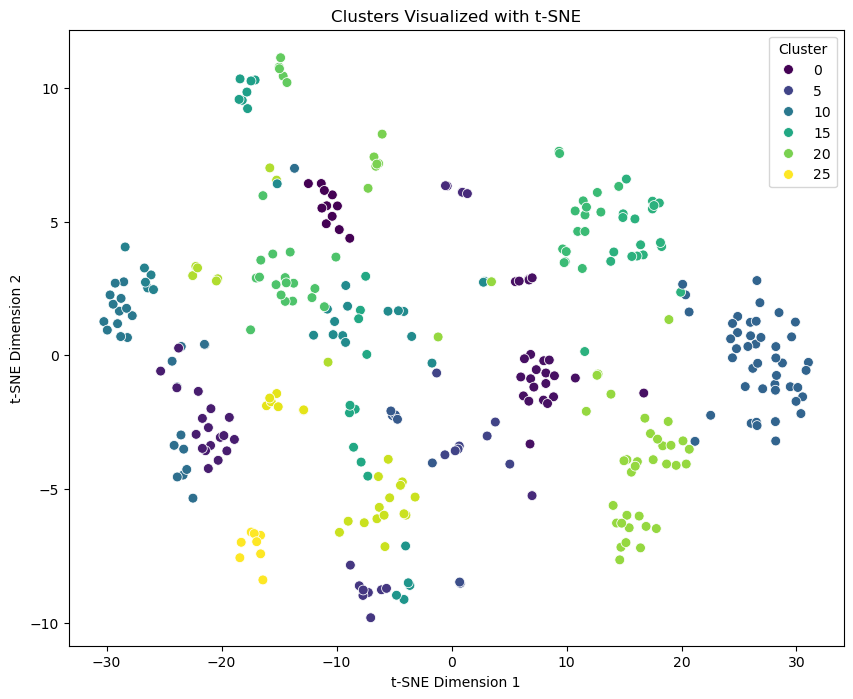

In [57]:
from sklearn.cluster import AffinityPropagation
# Perform Affinity clustering
affinity = AffinityPropagation(random_state=42)
cluster_labels = affinity.fit_predict(features)
# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.title("Clusters Visualized with t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster", loc='best')
plt.show()

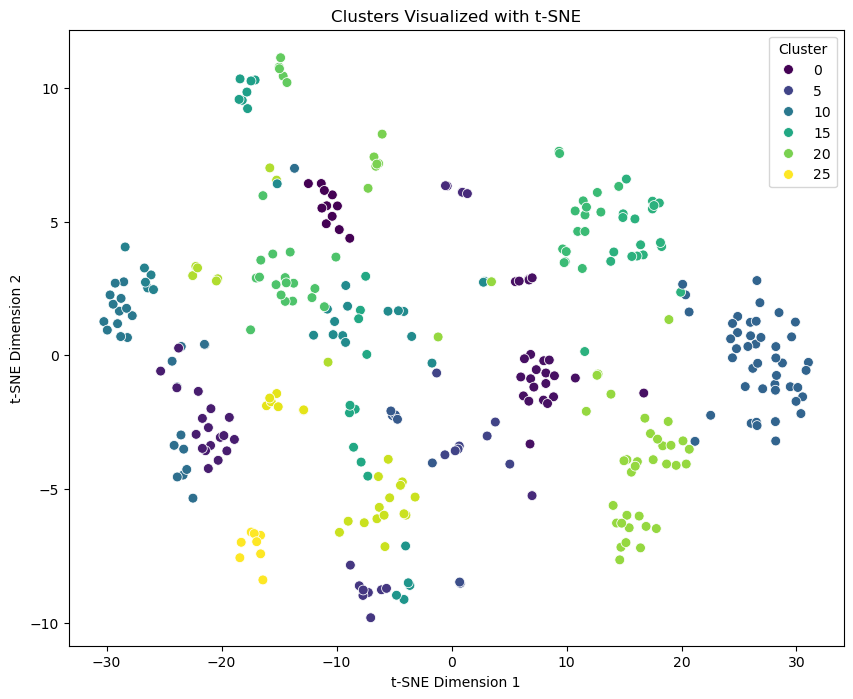

In [58]:
# Perform Affinity clustering
affinity = AffinityPropagation(random_state=42)
cluster_labels = affinity.fit_predict(features)
# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.title("Clusters Visualized with t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster", loc='best')
plt.show()

In [59]:
unique_clusters = np.unique(cluster_labels)
print(f"Number of clusters: {len(unique_clusters)}")

Number of clusters: 26
